<div class="alert alert-block alert-success">
    
# FIT5196 Task 1 in Assessment 1
#### Student Name: Manh Tung Vu, Ilya
#### Student ID: 30531438, 34466029

Date: 28/08/2024


Environment: Python 3.10.12

Libraries used:
* re (for regular expression, installed and imported)
* pandas (for data manipulation)
* os (to work with directories)
* json (to work with JSON)
    
</div>

<div class="alert alert-block alert-warning">

## 1.  Introduction and Objective  <a class="anchor" name="Intro"></a>
    
</div>

This assessment involves extracting and processing data from semi-structured text files containing user reviews. The dataset consists of 15 .txt files in a mis-structured XML format, each file containing various information about user reviews on Google Maps from California. The reviews include the following attributes:

*	**user_id**: ID of the reviewer
*	**name**: Name of the reviewer
*	**time**: Time of the review (in Unix time)
*	**rating**: Rating of the business
*	**text**: Text of the review
*	**pics**: Pictures included in the review
*	**resp**: Business response to the review, including Unix time and the text of the response
*	**gmap_id**: ID of the business

Additionally, an .xlsx file is provided, which contains 15 sheets with similar information, though some columns are empty.

**Objective**

The goal of this task is to extract and structure the data from these files into two separate output files:

1. CSV Output File: This file should contain the following columns:
* **gmap_id**: The ID of the business.
* **review_count**: The total number of reviews for a business.
* **review_text_count**: The number of reviews that contain text.
* **response_count**: The number of responses from a business.

2. JSON Output File: This file should include the following fields:
* **gmap_id**: The ID of the business.
* **reviews**: A root element containing one or more reviews, with each review including:
  * **user_id**: The ID of the reviewer.
	* **time**: The time of the review in UTC format (YYYY-MM-DD tt:hh:ss).
	* **review_rating**: The rating given by the reviewer.
	* **review_text**: The English text of the review, with emojis removed and the text normalized to lowercase. If the review is not in English, extract only the translated version. If there is no review text, the value should be “None”.
	* **if_pic**: A flag indicating if the review includes pictures (Y/N).
	* **pic_dim**: A list of tuples representing the dimensions of the pictures in the format [ [h,w], [h,w], ...]. If there are no pictures, the value should be an empty list [ ].
	* **if_response**: A flag indicating if the review has a response (Y/N).
* **earliest_review_date**: The earliest review date for a given business in the dataset, formatted as UTC (YYYY-MM-DD tt:hh:ss).
* l**atest_review_date**: The latest review date for a given business in the dataset, formatted as UTC (YYYY-MM-DD tt:hh:ss).

<div class="alert alert-block alert-warning">
    
## 2.  Importing Libraries  <a class="anchor" name="libs"></a>
 </div>

The packages to be used in this assessment are imported in the following. They are used to fulfill the following tasks:

* **re:** Applied for pattern matching and text processing to clean and extract information from the semi-structured text files.
* **pandas:** Used for data manipulation and analysis, particularly for reading, processing, and structuring data from Excel files and preparing the final CSV output.
* **json**: Utilized to structure and output the review data into the required JSON format.
* **OS:** Used for file and directory management, enabling the navigation and handling of .txt and .xlsx files within the project directory.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import json
import re
import os

<div class="alert alert-block alert-warning">

## 3.  Loading and Parsing Files <a class="anchor" name="load"></a>

</div>

## Tag processing
This code has been writen to be sure that we don't miss any tag

####Define some useful classes and functions

In [4]:
class tag_re:
  """
    A class for performing regular expression-based tag extraction from text lines.

    This class allows for defining start and end regular expressions to find and extract
    specific patterns or tags within a string. It includes methods to find values
    between start and end tags, as well as methods to identify start and end tags
    themselves.

    Attributes:
        re_st (str): The regular expression pattern for the start tag.
        re_end (str): The regular expression pattern for the end tag.

    Methods:
        get_tags_from_groups(groups):
            Static method that processes matched groups from a regex search
            and returns a list of the longest tags within each group.

        find_value(line):
            Finds and returns all substrings in the line that are between the
            start and end tag patterns.

        find_start_tags(line):
            Finds and returns all start tags in the line based on the start tag pattern.

        find_end_tags(line):
            Finds and returns all end tags in the line based on the end tag pattern.
  """
  def __init__(self, re_st, re_end):
    self.re_st = re_st
    self.re_end = re_end

  @staticmethod
  def get_tags_from_groups(groups):
    """
        Processes matched groups and returns a list of the longest tags within each group.

        Args:
            groups (list): A list of matched groups from a regex search. Each group
                           can either be a string or a list of strings.

        Returns:
            list: A list of the longest strings (tags) within each group.
    """
    if len(groups) == 0:
      return []
    if type(groups[0]) is str:
      tags = groups
    else:
      tags = []
      for g in groups:
        tag = g[0]
        for e in g:
          if len(e) > len(tag):
            tag = e
        tags.append(tag)
    return tags

  def find_value(self, line):
    """
        Finds and returns all substrings in the line between the start and end tag patterns.

        Args:
            line (str): The input string where the search is performed.

        Returns:
            list: A list of strings found between the start and end tag patterns.
    """
    pattern = self.re_st + r'(.*?)' + self.re_end
    groups = re.findall(pattern, line)
    return list(groups)

  def find_start_tags(self, line):
    """
        Finds and returns all start tags in the line based on the start tag pattern.

        Args:
            line (str): The input string where the search is performed.

        Returns:
            list: A list of start tags found in the line.
      """
    pattern = self.re_st
    groups = re.findall(pattern, line)
    return self.get_tags_from_groups(groups)

  def find_end_tags(self, line):
    """
        Finds and returns all end tags in the line based on the end tag pattern.

        Args:
            line (str): The input string where the search is performed.

        Returns:
            list: A list of end tags found in the line.
      """
    pattern = self.re_end
    groups = re.findall(pattern, line)
    return self.get_tags_from_groups(groups)

In [5]:
def copy_set(input_set):
  """ Create a copy of the set
  """
  lst = []
  for e in input_set:
    lst.append(e)
  return set(lst)

In [6]:
def remove_values_from_set(input_set: set, values_to_remove: list)->set :
  """Remove values from the input set and return the resulting set.
  """
  my_set = copy_set(input_set)
  for value in values_to_remove:
    if value in input_set:
      try:
        my_set.remove(value)
      except KeyError:
        pass
  return my_set

In [9]:
def create_replacing_dict(tags: list, tags_dict: dict)-> dict:
  """
    Creates a dictionary for replacing start and end tags in a text based on provided tags and tag definitions.

    This function generates a replacement dictionary where each key-value pair corresponds to
    the replacement of a start or end tag with the appropriate tag format. It uses the `tags_dict`
    to determine the start and end tags and their replacements based on the given `tags` list.

    Args:
        tags (list): A list of tag names to consider for replacement.
        tags_dict (dict): A dictionary where each key is a tag name and each value is an object
                          with methods `find_start_tags` and `find_end_tags` to retrieve start
                          and end tags respectively.

    Returns:
        dict: A dictionary where keys are the tags to be replaced and values are the corresponding
              replacement tags, formatted with angle brackets and slashes as appropriate.
  """
  replacing_dict = {}
  for key, value in tags_dict.items():
    st_v = value.find_start_tags(data2)
    for v in st_v:
      replacing_dict[r'<'+v+r'>'] = r'<'+key+r'>'
    end_v = value.find_end_tags(data2)
    for v in end_v:
      replacing_dict[r'<'+v+r'>'] = r'</'+key+r'>'
  return replacing_dict

def replace_tags(data: str, replacing_dict: dict)-> str:
  """
    Replaces tags in the given text based on a replacement dictionary.

    This function iterates over the `replacing_dict` and replaces occurrences of each key in the
    `data` string with the corresponding value from the dictionary.

    Args:
        data (str): The input string where tag replacements will be performed.
        replacing_dict (dict): A dictionary where keys are the tags to be replaced and values
                               are the replacement tags.

    Returns:
        str: The modified string with tags replaced according to the `replacing_dict`.
  """
  for key, value in replacing_dict.items():
    data = data.replace(key, value)
  return data

In [10]:
def check_missing_tags(data2, tags_dict):
  '''
  Identify missing tags in the given text based on a dictionary of expected tags.

    Args:
        data2 (str): The text data containing tags.
        tags_dict (dict): A dictionary where keys are tag types and values are objects
                          with methods to find start and end tags.

    Returns:
        set: A set of tags that are present in the text but not accounted for by the expected tags.
  '''
  # find all tags in the text
  pattern = r'<(.*?)>'
  groups = re.findall(pattern, data2, flags=re.DOTALL)
  set_of_tags = set(groups)
  # remove tags with found patterns
  set_of_tags_resid = set_of_tags.copy()
  for key, value in tags_dict.items():
    set_of_tags_resid = remove_values_from_set(set_of_tags_resid, value.find_start_tags(data2) + value.find_end_tags(data2))
  return set_of_tags_resid

In [11]:
def read_all_files_by_type(directory_path, file_ext):
  '''
  Read all files of a specified type from a directory and return their contents.

    Args:
        directory_path (str): The path to the directory containing the files.
        file_ext (str): The file extension to filter files by (e.g., 'xml').

    Returns:
        list: A list of strings, each representing the content of a file with the specified extension.
  '''
  xml_files_as_text = []
  for filename in os.listdir(directory_path):
    if filename.endswith('.'+file_ext):
      with open(os.path.join(directory_path, filename), 'r') as f:
        xml_files_as_text.append(f.read())
  return xml_files_as_text


#### Regex patterns

We define regex patterns to capture both opening and closing tags. Here is the visualization for the user opening and user closing tags. Other tags, such as those for name, gmap_id, time, rating, and so on, follow a similar pattern.

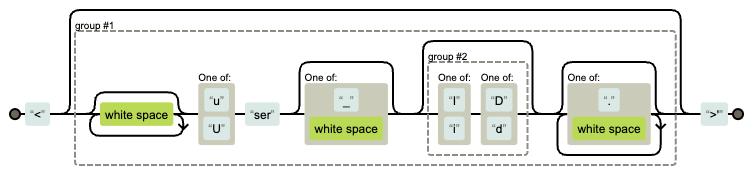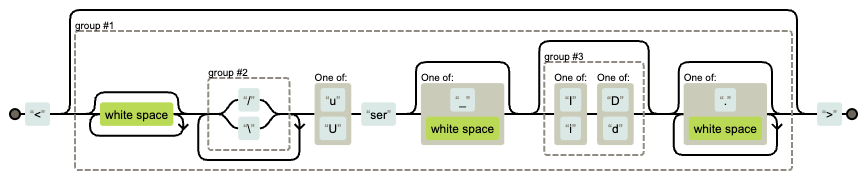

In [8]:
# tags pattern to find data in the record
tags_dict = {
    "user_id": tag_re(re_st = r'<(\s*[uU]ser[_\s]?([Ii][Dd])?[\.\s]*)?>', re_end = r'<(\s*(\/|\\)+[uU]ser[_\s]?([Ii][Dd])?[\.\s]*)?>'),
    "name": tag_re(re_st = r'<(([^\/\\\<\>])*[Nn]ame\s*)?>', re_end = r'<(\s*(\/|\\)+([^\<\>])*[Nn]ame\s*)?>'),
    "gmap_id": tag_re(re_st = r'<(([^\/\\\<\>])*[Gg]map[_\s]?([Ii][Dd])?\s*)?>', re_end = r'<(\s*(\/|\\)+[Gg]map[_\s]?([Ii][Dd])?\s*)?>'),
    "rating": tag_re(re_st = r'<(([^\/\\\<\>])*[Rr]at(e|(ing))\s*)?>', re_end = r'<(\s*(\/|\\)+[Rr]at(e|(ing))\s*)?>'),
    "time": tag_re(re_st = r'<(([^\/\\\<\>])*(([Dd]ate)|([Tt]ime))\s*)?>', re_end = r'<(\s*(\/|\\)+(([Dd]ate)|([Tt]ime))\s*)?>'),
    "pics": tag_re(re_st = r'<(([^\/\\\<\>])*[Pp]ic(ture)?s\s*)?>', re_end = r'<(\s*(\/|\\)+[Pp]ic(ture)?s\s*)?>'),
    "resp": tag_re(re_st = r'<(([^\/\\\<\>])*[Rr]esp(onse)?\s*)?>', re_end = r'<(\s*(\/|\\)+[Rr]esp(onse)?\s*)?>'),
    "text": tag_re(re_st = r'<(([^\/\\\<\>])*(([Rr]eview)|([Tt]ext))\s*)?>', re_end = r'<(\s*(\/|\\)+(([Rr]eview)|([Tt]ext))\s*)?>')
}
# tag pattern to find a record
record_tag = tag_re(re_st = r'<(([^\/\\\<\>])*[Rr]ecord\s*)?>', re_end = r'<(\s*(\/|\\)+[Rr]ecord\s*)?>')
dataset_tag = tag_re(re_st = r'<(([^\/\\\<\>])*[Dd]ataset\s*)?>', re_end = r'<(\s*(\/|\\)+[Dd]ataset\s*)?>')

# dictionary of all tags
tags_dict_full = {}
for key, value in tags_dict.items():
  tags_dict_full[key] = value
tags_dict_full["record"] = record_tag
tags_dict_full["dataset"] = dataset_tag

#### Check tag
Look at everything with looks like a tag in all txt files to check that we processed all tags

In [12]:
shared_path = '/content/drive/Shareddrives/FIT5196_S2_2024/GroupAssessment1/Student Data/student_group044/'

# read all txt files
xml_files = read_all_files_by_type(shared_path, 'txt')


In [14]:
set_of_tags_resid = set()
# analyse all tags from txt files
for data in xml_files:
  # remove new line symbol for easier processing
  data2 = data.replace('\n', ' ')
  set_of_tags_resid =set_of_tags_resid.union(check_missing_tags(data2, tags_dict_full))
print(f"We found other {len(set_of_tags_resid)} candidate to be a tag")
print(set_of_tags_resid)

We found other 6 candidate to be a tag
{'3 this place!< /Text', '3< /Text', ' br /', '3<//Review', "3 It wasn't so expensive too. I love this restaurant! <3< /review", '3<//text'}


'<3' - this is an emoji, this is not part of tag, so we ignored it here
'< br />' - this is not from xml schema, so we ignored it here

So, we find all tags in txt files


## Transfer data from files into one table

Replace invalid tags by valid ones for convenience


Then delete <dataset> tags because they are redundant for analysis

In [16]:
def transfer_into_readable_format(data, tags_dict):
  data2 = data.replace('\n', '')
  set_of_tags_resid = check_missing_tags(data2, tags_dict)
  # find all tags in the text
  pattern = r'<(.*?)>'
  groups = re.findall(pattern, data2, flags=re.DOTALL)
  set_of_tags = set(groups)
  set_of_tags = remove_values_from_set(set_of_tags, set_of_tags_resid)
  replacing_dict = create_replacing_dict(list(set_of_tags), tags_dict)
  replaced_data = replace_tags(data2, replacing_dict)

  replaced_data = replaced_data.replace('<dataset>', '')
  replaced_data = replaced_data.replace('</dataset>', '')
  replaced_data = replaced_data.replace('?xml version="1.0" encoding="UTF-8"?>', '')
  return replaced_data

In [17]:
def dict_from_record(record, columns_names):
  '''
  Extract values from an XML-like record and return them in a dictionary.

  Args:
      Record (str): A string containing the XML-like record with tags.
      columns_names (list): A list of tag names to extract from the record.

  Returns:
      dict: A dictionary where keys are column names and values are the extracted content from the tags.

  Raises:
      Exception: If the record does not contain exactly one value for any tag, an exception is raised.
  '''
  dict_to_return = {}
  for c in columns_names:
    pattern = r'<'+c+r'>(.*?)</'+c+r'>'
    groups = re.findall(pattern, record, flags=re.DOTALL)
    if len(groups) == 1:
      if groups[0] != 'None':
        dict_to_return[c] = groups[0]
    else:
      raise Exception("Invalid record")
  return dict_to_return


According to the tag analysis, we found that every record contains 8 useful part of infomation inside the corresponding tags. Extract this information from the records and put it in dataframe with corresponding columns names.

In [18]:
columns_names = ["user_id", "name", "gmap_id", "rating", "time", "pics", "text", "resp"]

In [19]:
# collect all data from txt files in readable format
all_data_as_text = ''

for data in xml_files:
  all_data_as_text += transfer_into_readable_format(data, tags_dict)

In [23]:
# find all records
pattern = r'<record>(.*?)</record>'
groups = re.findall(pattern, all_data_as_text, flags=re.DOTALL)
#print(groups[0:10])
lst_of_records = []
for g in groups:
  lst_of_records.append(dict_from_record(g, columns_names))
df_txt = pd.DataFrame(lst_of_records)
print(f"The table contain {df_txt.shape[0]} rows and {df_txt.shape[1]} columns")
df_txt.head(3)



The table contain 37238 rows and 8 columns


,user_id,name,gmap_id,rating,time,text,pics,resp
0,112719713920774405977,Michael Tobin,0x80843e0cb60c8a03:0x32689617e649dd,5,1620010204081,Easy to find. Ample parking. Clean and well ma...,NaN,NaN
1,114901332261800480467,Email1 Email1,0x80843e0cb60c8a03:0x32689617e649dd,4,1606695355662,Very good hamburger with fries,[{'url': ['https://lh5.googleusercontent.com/p...,NaN
2,113070762898265821562,Morgan H.,0x80843e0cb60c8a03:0x32689617e649dd,5,1614153821539,Everything one could enjoy/need in one locatio...,NaN,NaN


## Process excel files

After processing '.txt' file, we will process our '.xlsx' file. First, we create a function that will convert all excel files in a directory path to a dataframe. The function is documented below.

In [24]:
def convert_all_excel_files_to_df(directory_path):
  """
    Converts all Excel files in the specified directory to a single pandas DataFrame.

    This function reads all Excel files (.xls and .xlsx) in the given directory,
    combines all sheets from each file into a single DataFrame, and then concatenates
    the DataFrames from all files into one DataFrame.

    Args:
        directory_path (str): The path to the directory containing the Excel files.

    Returns:
        pd.DataFrame: A DataFrame containing the concatenated data from all sheets
                      of all Excel files in the specified directory.
    """
  df_lst = []
  for filename in os.listdir(directory_path):
    if filename.endswith('.xls') or filename.endswith('.xlsx'):
      sheets_dict = pd.read_excel(directory_path+filename, sheet_name=None)
      df_lst.append(pd.concat(sheets_dict.values()))
  df = pd.concat(df_lst)
  return df

Our excel file is then converted to dataframe using the above function.

In [25]:
df_excel = convert_all_excel_files_to_df(shared_path)
# Inspect the dataframe
print(f"The table contain {df_excel.shape[0]} rows and {df_excel.shape[1]} columns")
df_excel.tail(3)

The table contain 1508 rows and 13 columns


,x4,x1,user_id,name,time,rating,text,pics,resp,gmap_id,x2,x0,x3
121,NaN,NaN,115829755960266389211,Ed Skera,1.476668e+12,5.0,NaN,NaN,NaN,0x80946f1be20c0021:0xf31cac117063889c,NaN,NaN,NaN
122,NaN,NaN,103552026801689057585,Byron Gibson,1.555273e+12,5.0,NaN,NaN,NaN,0x80946f1be20c0021:0xf31cac117063889c,NaN,NaN,NaN
123,NaN,NaN,111188523501311788376,Joshua,1.540175e+12,5.0,NaN,NaN,NaN,0x80946f1be20c0021:0xf31cac117063889c,NaN,NaN,NaN


Remove from dataframe all empty columns and rows

In [26]:
# Remove all empty columns and rows
df_excel.dropna(how='all', axis=1, inplace=True)
df_excel.dropna(how='all', axis=0, inplace=True)

# Inspect the datafarme
print(f"The table contain {df_excel.shape[0]} rows and {df_excel.shape[1]} columns")
df_excel.tail(3)

The table contain 1471 rows and 8 columns


,user_id,name,time,rating,text,pics,resp,gmap_id
121,115829755960266389211,Ed Skera,1.476668e+12,5.0,NaN,NaN,NaN,0x80946f1be20c0021:0xf31cac117063889c
122,103552026801689057585,Byron Gibson,1.555273e+12,5.0,NaN,NaN,NaN,0x80946f1be20c0021:0xf31cac117063889c
123,111188523501311788376,Joshua,1.540175e+12,5.0,NaN,NaN,NaN,0x80946f1be20c0021:0xf31cac117063889c


We have our dataframe from '.txt' files and from '.xlsx' file(s). Now we need to concatenate them into one dataframe for further processing. We will use pd.concat() function. The names of the columns are the same, so we just concatinate two dataframes

In [28]:
# Concatenate all data
df = pd.concat([df_txt, df_excel])
df.dropna(how='all', axis=1, inplace=True)
df.dropna(how='all', axis=0, inplace=True)

# Inspect the dataframe
print(f"The table contain {df.shape[0]} rows and {df.shape[1]} columns")
df.tail()

The table contain 38709 rows and 8 columns


,user_id,name,gmap_id,rating,time,text,pics,resp
119,108212123856668066158,Mia Stokes,0x80946f1be20c0021:0xf31cac117063889c,4.0,1557082644540.0,NaN,NaN,NaN
120,108267243742576830688,Bill Faught,0x80946f1be20c0021:0xf31cac117063889c,5.0,1594245913459.0,NaN,NaN,NaN
121,115829755960266389211,Ed Skera,0x80946f1be20c0021:0xf31cac117063889c,5.0,1476667865059.0,NaN,NaN,NaN
122,103552026801689057585,Byron Gibson,0x80946f1be20c0021:0xf31cac117063889c,5.0,1555272856994.0,NaN,NaN,NaN
123,111188523501311788376,Joshua,0x80946f1be20c0021:0xf31cac117063889c,5.0,1540175195724.0,NaN,NaN,NaN


## Processing dataframe

We will further process our dataframe by casting the correct datatypes for each columns, removing duplicated entries, and creating new columns based on assignment requirements.

#### Reorder and re-name columns

In [29]:
# Reorder and re-name columns
new_order = ['user_id', 'name', 'gmap_id', 'rating', 'time', 'pics', 'text', 'resp']
df = df[new_order]
df = df.rename(columns={"time":"time_ms"}) # we want to keep this column for task 3 processing, so we have just renamed it

# Inspect the dataframe
print(f"The table contain {df.shape[0]} rows and {df.shape[1]} columns")
df.tail(3)

The table contain 38709 rows and 8 columns


,user_id,name,gmap_id,rating,time_ms,pics,text,resp
121,115829755960266389211,Ed Skera,0x80946f1be20c0021:0xf31cac117063889c,5.0,1476667865059.0,NaN,NaN,NaN
122,103552026801689057585,Byron Gibson,0x80946f1be20c0021:0xf31cac117063889c,5.0,1555272856994.0,NaN,NaN,NaN
123,111188523501311788376,Joshua,0x80946f1be20c0021:0xf31cac117063889c,5.0,1540175195724.0,NaN,NaN,NaN


#### Remove dublicates

In [30]:
# Remove dublicates
df = df.drop_duplicates()
print(f"The table contain {df.shape[0]} rows and {df.shape[1]} columns")
df.head(3)

The table contain 37706 rows and 8 columns


,user_id,name,gmap_id,rating,time_ms,pics,text,resp
0,112719713920774405977,Michael Tobin,0x80843e0cb60c8a03:0x32689617e649dd,5,1620010204081,NaN,Easy to find. Ample parking. Clean and well ma...,NaN
1,114901332261800480467,Email1 Email1,0x80843e0cb60c8a03:0x32689617e649dd,4,1606695355662,[{'url': ['https://lh5.googleusercontent.com/p...,Very good hamburger with fries,NaN
2,113070762898265821562,Morgan H.,0x80843e0cb60c8a03:0x32689617e649dd,5,1614153821539,NaN,Everything one could enjoy/need in one locatio...,NaN


#### Convert into target types

In [32]:
# Convert rating into int type value
df['rating'] = df['rating'].astype(int)
print(f"The table contain {df.shape[0]} rows and {df.shape[1]} columns")
print("\nList of columns with types:")
print(df.dtypes)
print("\n")
df.head(3)

The table contain 37706 rows and 8 columns

List of columns with types:
user_id    object
name       object
gmap_id    object
rating      int64
time_ms    object
pics       object
text       object
resp       object
dtype: object




,user_id,name,gmap_id,rating,time_ms,pics,text,resp
0,112719713920774405977,Michael Tobin,0x80843e0cb60c8a03:0x32689617e649dd,5,1620010204081,NaN,Easy to find. Ample parking. Clean and well ma...,NaN
1,114901332261800480467,Email1 Email1,0x80843e0cb60c8a03:0x32689617e649dd,4,1606695355662,[{'url': ['https://lh5.googleusercontent.com/p...,Very good hamburger with fries,NaN
2,113070762898265821562,Morgan H.,0x80843e0cb60c8a03:0x32689617e649dd,5,1614153821539,NaN,Everything one could enjoy/need in one locatio...,NaN


In [33]:
df2 = df.copy(deep=True)
df2['time'] = pd.to_datetime(df2['time_ms'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
print(f"The table contain {df2.shape[0]} rows and {df2.shape[1]} columns")
print("\nList of columns with types:")
print(df2.dtypes)
print("\n")
df2.head(3)

<ipython-input-33-7ca7cf7bedb6>:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df2['time'] = pd.to_datetime(df2['time_ms'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')


The table contain 37706 rows and 9 columns

List of columns with types:
user_id    object
name       object
gmap_id    object
rating      int64
time_ms    object
pics       object
text       object
resp       object
time       object
dtype: object




,user_id,name,gmap_id,rating,time_ms,pics,text,resp,time
0,112719713920774405977,Michael Tobin,0x80843e0cb60c8a03:0x32689617e649dd,5,1620010204081,NaN,Easy to find. Ample parking. Clean and well ma...,NaN,2021-05-03 02:50:05
1,114901332261800480467,Email1 Email1,0x80843e0cb60c8a03:0x32689617e649dd,4,1606695355662,[{'url': ['https://lh5.googleusercontent.com/p...,Very good hamburger with fries,NaN,2020-11-30 00:16:27
2,113070762898265821562,Morgan H.,0x80843e0cb60c8a03:0x32689617e649dd,5,1614153821539,NaN,Everything one could enjoy/need in one locatio...,NaN,2021-02-24 08:02:57


#### Create new columns

We'll add "if_pic" and "if_response" columns into our dataframe. "if_pics" takes value "Y" if there is a pictures and "N" otherwise. Similarly, "if_response" takes value "Y" if there is a response and "N" otherwise. We will apply a function to the corresponding column and take that value into a new column.

In [34]:
# Add If_pic, If_response columns
df2['if_pic'] = df2['pics'].apply(lambda x: 'Y' if pd.notna(x) else 'N')
df2['if_response'] = df2['resp'].apply(lambda x: 'Y' if pd.notna(x) else 'N')

# Inspect the dataframe
print(f"The table contain {df2.shape[0]} rows and {df2.shape[1]} columns")
print("\nList of columns with types:")
print(df2.dtypes)
print("\n")
df2.head(3)

The table contain 37706 rows and 11 columns

List of columns with types:
user_id        object
name           object
gmap_id        object
rating          int64
time_ms        object
pics           object
text           object
resp           object
time           object
if_pic         object
if_response    object
dtype: object




,user_id,name,gmap_id,rating,time_ms,pics,text,resp,time,if_pic,if_response
0,112719713920774405977,Michael Tobin,0x80843e0cb60c8a03:0x32689617e649dd,5,1620010204081,NaN,Easy to find. Ample parking. Clean and well ma...,NaN,2021-05-03 02:50:05,N,N
1,114901332261800480467,Email1 Email1,0x80843e0cb60c8a03:0x32689617e649dd,4,1606695355662,[{'url': ['https://lh5.googleusercontent.com/p...,Very good hamburger with fries,NaN,2020-11-30 00:16:27,Y,N
2,113070762898265821562,Morgan H.,0x80843e0cb60c8a03:0x32689617e649dd,5,1614153821539,NaN,Everything one could enjoy/need in one locatio...,NaN,2021-02-24 08:02:57,N,N


The next column we need to create is "pic_dim". This column contains a list of dimension if the value in "if_pic" is "Y", otherwise "pic_dim" is an empty list [].

An extract_pic_dim function is created to extract picture dimensions from the url in 'picture' column. The regular expression we used is ![pic_dim_regex_visualisation.png]r"=w(\d*)-h(\d*)-k-no-p" since the picture dimensions are followed by "-k-no-p" and we need to capture the phrase after "w" and "h". This is the visualisation of the regular expression.

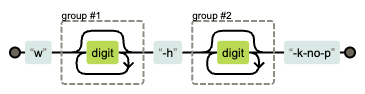


In [35]:
def extract_pic_dim(url):
  """
    Extracts picture dimensions from a URL.

    Searches for dimensions in the format `=w<width>-h<height>` and returns them as [height, width].

    Args:
        url (str or pd.NA): URL containing dimensions or `pd.NA` for missing data.

    Returns:
        list: List of dimensions as [height, width]. Empty if no dimensions found or if URL is missing.
  """
  if pd.isna(url):
    return []
  pic_dim = []
  dim_lst = re.findall(r"=w(\d*)-h(\d*)-k-no-p", url)
  for pic in dim_lst:
  # we need [height, width] but the findall method returns [width, height]
    pic_dim.append([pic[1], pic[0]])
  return pic_dim

We apply the function to 'pics' column to get the values for 'pic_dim' column.

In [36]:
df2['pic_dim'] = df2['pics'].apply(extract_pic_dim)
print(f"The table contain {df2.shape[0]} rows and {df2.shape[1]} columns")
print("\nList of columns with types:")
print(df2.dtypes)
print("\n")
df2.head(3)

The table contain 37706 rows and 12 columns

List of columns with types:
user_id        object
name           object
gmap_id        object
rating          int64
time_ms        object
pics           object
text           object
resp           object
time           object
if_pic         object
if_response    object
pic_dim        object
dtype: object




,user_id,name,gmap_id,rating,time_ms,pics,text,resp,time,if_pic,if_response,pic_dim
0,112719713920774405977,Michael Tobin,0x80843e0cb60c8a03:0x32689617e649dd,5,1620010204081,NaN,Easy to find. Ample parking. Clean and well ma...,NaN,2021-05-03 02:50:05,N,N,[]
1,114901332261800480467,Email1 Email1,0x80843e0cb60c8a03:0x32689617e649dd,4,1606695355662,[{'url': ['https://lh5.googleusercontent.com/p...,Very good hamburger with fries,NaN,2020-11-30 00:16:27,Y,N,"[[150, 150], [150, 150], [150, 150], [150, 150..."
2,113070762898265821562,Morgan H.,0x80843e0cb60c8a03:0x32689617e649dd,5,1614153821539,NaN,Everything one could enjoy/need in one locatio...,NaN,2021-02-24 08:02:57,N,N,[]


#### Review texts processing

In [37]:
def remove_emoji(text):
  """
    Removes emojis from a given text string.

    Uses a regular expression to identify and remove emoji characters from the text.

    Args:
        text (str): The input string from which emojis will be removed.

    Returns:
        str: The input string with all emojis removed.
  """
  emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F1E0-\U0001F1FF"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE
    )
  return emoji_pattern.sub('', text)

In [38]:
# Test our remove emoji function

str_1 = "The best pizza 🍕  just love it!!!" #.encode('utf-8')
str_2 = "It is so good when I tried it I fell in love with the ice cream 😎👍🤩😁 Thanks"
print(str_2)
remove_emoji(str_2)

It is so good when I tried it I fell in love with the ice cream 😎👍🤩😁 Thanks


'It is so good when I tried it I fell in love with the ice cream 🤩 Thanks'

Take into account, we deleted only emojis according to the provided pattern.

We create a text_processing function that will process the text as per assignment requirements: lowercaase text, no emoji, and all in English.

The regular expression pattern for extracting English translation is r"\(translated by google\)\s?(.*)\(original\)" because the English translation is between '(translated by google)' and '(original)'. The visualisation for this regex is below.

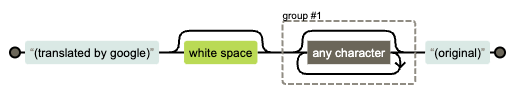


In [39]:
# Test our regex for extracting English text from Google review

str_1 = "(Translated by Google) They are rats\n\n(Original)\nSon unas ratas"
str_2 = "(Translated by Google) Yummy. Delicious. Tasty. Very tasty.\n\n(Original)\nYummy. Delicious. Tasty. Muy sabroso."
str_3 = "Better than doc burnsteins"
pattern_tr = r'\(translated by google\)\s?(.*)\(original\)'
extracted_text1 = re.findall(pattern_tr, str_1.lower(), flags=re.DOTALL)
extracted_text2 = re.findall(pattern_tr, str_2.lower(), flags=re.DOTALL)
extracted_text3 = re.findall(pattern_tr, str_3.lower(), flags=re.DOTALL)
print(extracted_text1)
print(extracted_text2)
print(extracted_text3)

['they are rats\n\n']
['yummy. delicious. tasty. very tasty.\n\n']
[]


Next, we create a text_processing function that would process our review text as per assignment requirements. The details of the function is below.

In [40]:
def text_processing(text):
  """
    Processes a text string by removing emojis, converting to lowercase, and handling specific patterns.

    The function performs the following operations:
    1. Removes emojis from the text using the `remove_emoji` function.
    2. Converts the text to lowercase.
    3. Replaces newline characters with spaces.
    4. Extracts text that matches a specific pattern related to translations if present.
    5. Returns 'None' if the input text is missing.

    Args:
        text (str or pd.NA): The input text to be processed. If `pd.NA`, the function will return Python NoneType None.

    Returns:
        str: The processed text with emojis removed, in lowercase, and with specific patterns handled.
              Returns 'None' if the input is missing.
  """
  if pd.notna(text):
    text = remove_emoji(text)
    text = text.lower()
    text = text.replace('\n', ' ')
    pattern_tr = r'\(translated by google\)\s?(.*)\(original\)'
    extracted_text2 = re.findall(pattern_tr, text, flags=re.DOTALL)
    if len(extracted_text2) > 0:
      text = extracted_text2[0]
    #text = text.encode('utf-8')
  else:
    text = "None"
  return text



In [41]:
# Delete emoji, text not in English, normalise to lowercase
df3 = df2.copy(deep=True)
df3['text'] = df3['text'].apply(text_processing)
print(f"The table contain {df3.shape[0]} rows and {df3.shape[1]} columns")
df3[23:30].head()
#print(df3[df3['text'].isna()])

The table contain 37706 rows and 12 columns


,user_id,name,gmap_id,rating,time_ms,pics,text,resp,time,if_pic,if_response,pic_dim
23,117346160085827012997,Deea ideas,0x80843e0cb60c8a03:0x32689617e649dd,5,1622155356693,NaN,try mangos,NaN,2021-05-27 22:42:09,N,N,[]
24,116176829295963298436,Gustavo Mencalder,0x80843e0cb60c8a03:0x32689617e649dd,4,1591208793429,NaN,lots of idiots in the parking lot,NaN,2020-06-03 18:27:17,N,N,[]
25,107409356377298831682,Elizabeth Meza,0x80843e0cb60c8a03:0x32689617e649dd,2,1582562351882,NaN,None,NaN,2020-02-24 16:40:10,N,N,[]
26,115924600968195700199,Hannible Lecterh,0x80843e0cb60c8a03:0x32689617e649dd,5,1618042974453,NaN,None,NaN,2021-04-10 08:22:25,N,N,[]
27,101128480987536586640,Naelson gameplay,0x80843e0cb60c8a03:0x32689617e649dd,5,1619051013156,NaN,None,NaN,2021-04-22 00:23:40,N,N,[]


In [42]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37706 entries, 0 to 123
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      37706 non-null  object
 1   name         37706 non-null  object
 2   gmap_id      37706 non-null  object
 3   rating       37706 non-null  int64 
 4   time_ms      37706 non-null  object
 5   pics         1094 non-null   object
 6   text         37706 non-null  object
 7   resp         5687 non-null   object
 8   time         37706 non-null  object
 9   if_pic       37706 non-null  object
 10  if_response  37706 non-null  object
 11  pic_dim      37706 non-null  object
dtypes: int64(1), object(11)
memory usage: 4.7+ MB


## Create csv output

We have a cleaned dataframe with all the features we needed. Now, we will prepare our output dataframe by groupby and aggregating features in the cleaned dataframe.

Since we expect our csv output to have an aggregate count of review, review with text and response for each gmap_id, we will group them by gmap_id using groupby(by='gmap_id') then aggregate them.

1. df3.groupby(by='gmap_id'):
  * This groups the DataFrame df3 by the gmap_id column. Each unique gmap_id will form a separate group.

2. .agg(...):
  *  This method is used to apply aggregate functions to each group created by the groupby operation. It allows you to calculate various statistics for each group.

3.	review_count=('gmap_id', 'count'):
	* This calculates the total number of occurrences of each gmap_id in the DataFrame. It counts how many times each gmap_id appears, essentially giving the number of reviews for each gmap_id.

4.	review_text_count=('text', lambda x: x.notna().sum() - (x == 'None').sum()):
	* This counts the number of non-NaN or 'None' values in the text column for each gmap_id. It uses a lambda function to check if the values are not NaN (x.notna()), and then sums the number of non-NaN values. This effectively counts how many reviews have actual text content.

5.	resp_count=('resp', lambda x: x.notna().sum()):
	* Similarly, this counts the number of non-NaN values in the resp column for each gmap_id. It uses a lambda function to determine if the values are not NaN and sums these values. This gives the count of responses for each gmap_id.

In [44]:
# Create csv output dataframe
csv_output_df = df3.groupby(by='gmap_id').agg(
    review_count=('gmap_id','count'), #count total occurrences of gmapid
    review_text_count=('text', lambda x: x.notna().sum() - (x == 'None').sum()), #count non_NaN or None values in 'review'
    response_count=('resp', lambda x: x.notna().sum()) #Count non_NaN values in 'response'
)
print(f"The table contain {csv_output_df.shape[0]} rows and {csv_output_df.shape[1]} columns")
csv_output_df.head()


The table contain 176 rows and 3 columns


,review_count,review_text_count,response_count
gmap_id,,,
0x54d4000810cde343:0x144f867433fa0966,56,40,1
0x808164de5730862d:0xcb473d5d65fb1d39,77,50,0
0x808327ba5f197e6d:0x5e31fb9492a334e7,118,88,0
0x8084047107a176cb:0x889336c7010bad47,128,73,0
0x808437fdd8593cbb:0x813a0531fbb5eb48,58,39,4


Save result into csv file

In [47]:
csv_output_df.to_csv('/content/drive/MyDrive/FIT5196_assignment_files/task1_044.csv', encoding='utf-8')


## Create json output

Create a copy of the previous dataframe.

In [48]:
df4 = df3.copy(deep=True)


We will transform our dataframe to a dataframe that can be output to the required json format. The details of the function are below.

In [49]:
def create_sub_string(group):
  """
    Transforms a DataFrame into a list of dictionaries with specific column renaming and selection.

    This function performs the following operations:
    1. Selects specific columns from the input DataFrame and renames some of them.
    2. Converts the modified DataFrame into a list of dictionaries, where each dictionary represents a record.

    Args:
        group (pd.DataFrame): The input DataFrame containing columns 'user_id', 'time', 'rating', 'text',
                              'If_pic', 'pic_dim', and 'If_response'.

    Returns:
        list of dict: A list of dictionaries where each dictionary represents a record from the DataFrame
                      with columns 'user_id', 'time', 'review_rating', 'review_text', 'If_pic',
                      'pic_dim', and 'If_response'.
  """
  # transform columns
  group = group[['user_id', 'time', 'rating', 'text', 'if_pic', 'pic_dim', 'if_response']].rename(
            columns={"rating":"review_rating", "text": "review_text"}
        )
  # transform dataframe into dictionary format
  dict_ = group.to_dict(orient='records')

  return dict_

In [50]:
df4.head(3)

,user_id,name,gmap_id,rating,time_ms,pics,text,resp,time,if_pic,if_response,pic_dim
0,112719713920774405977,Michael Tobin,0x80843e0cb60c8a03:0x32689617e649dd,5,1620010204081,NaN,easy to find. ample parking. clean and well ma...,NaN,2021-05-03 02:50:05,N,N,[]
1,114901332261800480467,Email1 Email1,0x80843e0cb60c8a03:0x32689617e649dd,4,1606695355662,[{'url': ['https://lh5.googleusercontent.com/p...,very good hamburger with fries,NaN,2020-11-30 00:16:27,Y,N,"[[150, 150], [150, 150], [150, 150], [150, 150..."
2,113070762898265821562,Morgan H.,0x80843e0cb60c8a03:0x32689617e649dd,5,1614153821539,NaN,everything one could enjoy/need in one locatio...,NaN,2021-02-24 08:02:57,N,N,[]


In [52]:
# test the function
result = df4.groupby('gmap_id').apply(create_sub_string)
result.head(3)

,0
gmap_id,
0x54d4000810cde343:0x144f867433fa0966,"[{'user_id': '104081100673736832101', 'time': ..."
0x808164de5730862d:0xcb473d5d65fb1d39,"[{'user_id': '110427062422186823936', 'time': ..."
0x808327ba5f197e6d:0x5e31fb9492a334e7,"[{'user_id': '103254518375146657329', 'time': ..."


In [54]:
# Transform data into JSON format and save into the file
json_output_df = df4.groupby('gmap_id', group_keys=False).apply(
    lambda x: {
        "reviews": create_sub_string(x),
        "earliest_review_date": pd.to_datetime(x['time']).min().strftime('%Y-%m-%d %H:%M:%S'),
        "latest_review_date": pd.to_datetime(x['time']).max().strftime('%Y-%m-%d %H:%M:%S')
    }
)
json_output_df.to_json('/content/drive/MyDrive/FIT5196_assignment_files/task1_044.json', index=False)
json_output_df.head(3)


,0
gmap_id,
0x54d4000810cde343:0x144f867433fa0966,{'reviews': [{'user_id': '10408110067373683210...
0x808164de5730862d:0xcb473d5d65fb1d39,{'reviews': [{'user_id': '11042706242218682393...
0x808327ba5f197e6d:0x5e31fb9492a334e7,{'reviews': [{'user_id': '10325451837514665732...


In [55]:
# Produce a csv output for EDA later on
df4.to_csv('/content/drive/MyDrive/FIT5196_assignment_files/task1full.csv', encoding='utf-8')

## Conclusion

In this assessment, we successfully extracted and processed data from semi-structured text files and an Excel spreadsheet containing user reviews from Google Maps. The following key steps were accomplished:

1.	Data Extraction and Parsing: We efficiently parsed the mis-structured XML files and extracted relevant information, including user details, review content, ratings, and business responses. The data from the Excel sheets was also incorporated, with attention given to handling empty columns and aligning information with the text files.

2.	Data Structuring: The extracted data was organized into two output formats:
  * CSV Output File: This file was generated to summarize key metrics for each business, including the total number of reviews, the count of reviews containing text, and the number of business responses.
  * JSON Output File: This file was structured to include detailed review data, such as user IDs, review times in UTC format, ratings, normalized review texts, picture inclusion and dimensions, response presence, and review date ranges.

3.	Data Normalization and Cleaning: We ensured the review texts were cleaned by removing emojis and normalizing to lowercase. Non-English reviews were handled by extracting translated versions, and any missing review texts were appropriately flagged as “None.” Pictures and responses were flagged and detailed as specified.

4.	Temporal Analysis: The earliest and latest review dates for each business were calculated to provide insights into the review timeline and activity patterns.

## Reference

[1] Pandas DataFrame: Wes McKinney, "pandas: powerful Python data analysis toolkit," https://pandas.pydata.org/, Accessed 30/08/2024.

[2] JSON: Python Software Foundation, "json — JSON encoder and decoder," https://docs.python.org/3/library/json.html, Accessed 30/08/2024.

[3] re (Regular expression operations): Python Software Foundation, "re — Regular expression operations," https://docs.python.org/3/library/re.html, Accessed 30/08/2024.

[4] os (Miscellaneous operating system interfaces): Python Software Foundation, "os — Miscellaneous operating system interfaces," https://docs.python.org/3/library/os.html, Accessed 30/08/2024.

We acknowledge the use of Gen-AI (ChatGPT, Copylot and Gemini) to get some hints about specific Python libraries/functions/classes/methods/options/settings. Every information from AI has been found and double-checked in the original library manuals.  

